In [1]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.6 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import NormalizeFeatures
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Load the PROTEINS dataset
dataset = TUDataset(root='/tmp/PROTEINS', name='PROTEINS', transform=NormalizeFeatures())

# Define the GCN model for graph classification
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(42)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = torch.nn.Linear(hidden_channels, dataset.num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = global_mean_pool(x, batch)  # global mean pooling
        x = F.dropout(x, p=0.5, training=self.training)
        return x, self.lin(x)

# Initialize the model, optimizer, and dataloader
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

# Create data loaders
train_loader = DataLoader(dataset[:900], batch_size=32, shuffle=True)
test_loader = DataLoader(dataset[900:], batch_size=32, shuffle=False)

# Define the training loop
def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        optimizer.zero_grad()
        _, out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(train_loader.dataset)

# Define the test function
def test(loader):
    model.eval()
    correct = 0
    for data in loader:
        _, out = model(data)
        pred = out.argmax(dim=1)
        correct += pred.eq(data.y).sum().item()
    return correct / len(loader.dataset)

# Training loop
for epoch in range(1, 201):
    loss = train()
    if epoch % 10 == 0:
        train_acc = test(train_loader)
        test_acc = test(test_loader)
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

print('Training complete')


Processing...
Done!


Epoch: 010, Loss: 0.5423, Train Acc: 0.7367, Test Acc: 0.0000
Epoch: 020, Loss: 0.5437, Train Acc: 0.7456, Test Acc: 0.1221
Epoch: 030, Loss: 0.5493, Train Acc: 0.7367, Test Acc: 0.0000
Epoch: 040, Loss: 0.5359, Train Acc: 0.7400, Test Acc: 0.0516
Epoch: 050, Loss: 0.5419, Train Acc: 0.7400, Test Acc: 0.0610
Epoch: 060, Loss: 0.5340, Train Acc: 0.7367, Test Acc: 0.0000
Epoch: 070, Loss: 0.5418, Train Acc: 0.7367, Test Acc: 0.0000
Epoch: 080, Loss: 0.5429, Train Acc: 0.7367, Test Acc: 0.0000
Epoch: 090, Loss: 0.5352, Train Acc: 0.7444, Test Acc: 0.0704
Epoch: 100, Loss: 0.5508, Train Acc: 0.7367, Test Acc: 0.0000
Epoch: 110, Loss: 0.5448, Train Acc: 0.7367, Test Acc: 0.0000
Epoch: 120, Loss: 0.5352, Train Acc: 0.7400, Test Acc: 0.0516
Epoch: 130, Loss: 0.5390, Train Acc: 0.7367, Test Acc: 0.0000
Epoch: 140, Loss: 0.5373, Train Acc: 0.7400, Test Acc: 0.0563
Epoch: 150, Loss: 0.5360, Train Acc: 0.7367, Test Acc: 0.0000
Epoch: 160, Loss: 0.5360, Train Acc: 0.7400, Test Acc: 0.0516
Epoch: 1

In [8]:
import torch
from torch_geometric.data import Data, DataLoader
from torch_geometric.datasets import TUDataset

# Example using a pre-built dataset from PyTorch Geometric
dataset = TUDataset(root='/tmp/PROTEINS', name='PROTEINS')

# Split dataset into training and testing sets
torch.manual_seed(12345)
dataset = dataset.shuffle()
train_dataset = dataset[:len(dataset) // 10 * 8]
test_dataset = dataset[len(dataset) // 10 * 8:]

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [26]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool

class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 64)
        self.conv2 = GCNConv(64, 64)
        self.conv3 = GCNConv(64, 64)
        self.lin = torch.nn.Linear(64, dataset.num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = F.relu(x)

        # Pooling layer
        x = global_mean_pool(x, batch)

        # Final linear layer
        x = self.lin(x)

        return x

model = GNN()
print(model)

GNN(
  (conv1): GCNConv(3, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [27]:
from torch.optim import Adam

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
optimizer = Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def test(loader):
    model.eval()
    correct = 0
    for data in loader:
        data = data.to(device)
        out = model(data)
        pred = out.argmax(dim=1)
        correct += (pred == data.y).sum().item()
    return correct / len(loader.dataset)

for epoch in range(1, 100):
    loss = train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')


Epoch: 001, Loss: 0.6700, Train Acc: 0.6216, Test Acc: 0.6267
Epoch: 002, Loss: 0.6444, Train Acc: 0.6498, Test Acc: 0.6800
Epoch: 003, Loss: 0.6250, Train Acc: 0.6881, Test Acc: 0.6489
Epoch: 004, Loss: 0.6154, Train Acc: 0.7241, Test Acc: 0.6978
Epoch: 005, Loss: 0.6057, Train Acc: 0.7173, Test Acc: 0.6800
Epoch: 006, Loss: 0.5992, Train Acc: 0.7151, Test Acc: 0.6889
Epoch: 007, Loss: 0.6087, Train Acc: 0.6689, Test Acc: 0.6222
Epoch: 008, Loss: 0.6131, Train Acc: 0.7173, Test Acc: 0.6800
Epoch: 009, Loss: 0.6077, Train Acc: 0.7252, Test Acc: 0.7111
Epoch: 010, Loss: 0.6100, Train Acc: 0.6847, Test Acc: 0.6267
Epoch: 011, Loss: 0.6049, Train Acc: 0.6971, Test Acc: 0.6711
Epoch: 012, Loss: 0.5997, Train Acc: 0.6847, Test Acc: 0.7022
Epoch: 013, Loss: 0.6093, Train Acc: 0.7083, Test Acc: 0.6756
Epoch: 014, Loss: 0.6027, Train Acc: 0.6993, Test Acc: 0.6444
Epoch: 015, Loss: 0.6010, Train Acc: 0.6836, Test Acc: 0.6444
Epoch: 016, Loss: 0.6111, Train Acc: 0.7286, Test Acc: 0.6889
Epoch: 0

In [28]:
# prompt: classification report of model

from sklearn.metrics import classification_report

model.eval()
predictions = []
true_labels = []

for data in test_loader:
    data = data.to(device)
    out = model(data)
    predictions.extend(out.argmax(dim=1).tolist())
    true_labels.extend(data.y.tolist())

report = classification_report(true_labels, predictions)
print(report)


              precision    recall  f1-score   support

           0       0.70      0.87      0.77       131
           1       0.72      0.47      0.57        94

    accuracy                           0.70       225
   macro avg       0.71      0.67      0.67       225
weighted avg       0.71      0.70      0.69       225



In [30]:
# prompt: extract model activation and use tSNE cluster

# Extract model activation
activations = []
model.eval()
with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        _, out = model(data)
        activations.extend(out.tolist())

# Use tSNE to cluster activations
X_embedded = TSNE(n_components=2).fit_transform(activations)

# Plot clusters
plt.scatter(X_embedded[:, 0], X_embedded[:, 1])
plt.show()


ValueError: too many values to unpack (expected 2)

In [3]:
# prompt: classification report of model

from sklearn.metrics import classification_report

# Get the predictions for the test data
model.eval()
predictions = []
true_labels = []
for data in test_loader:
    _, out = model(data)
    predictions.extend(out.argmax(dim=1).tolist())
    true_labels.extend(data.y.tolist())

# Generate the classification report
report = classification_report(true_labels, predictions)
print(report)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00     213.0

    accuracy                           0.00     213.0
   macro avg       0.00      0.00      0.00     213.0
weighted avg       0.00      0.00      0.00     213.0



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

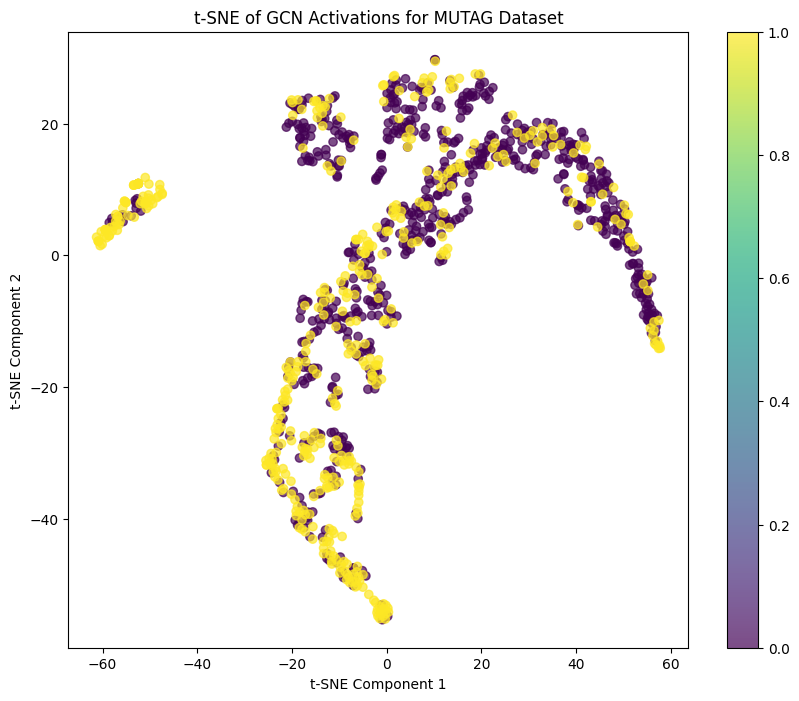

In [ ]:
# Extract activations for the entire dataset
def extract_activations(loader):
    model.eval()
    activations = []
    labels = []
    for data in loader:
        x, _ = model(data)
        activations.append(x)
        labels.append(data.y)
    activations = torch.cat(activations, dim=0)
    labels = torch.cat(labels, dim=0)
    return activations, labels

activations, labels = extract_activations(DataLoader(dataset, batch_size=32))

# Apply t-SNE to the activations
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=1000, random_state=42)
activations_tsne = tsne.fit_transform(activations.detach().cpu().numpy())

# Plot t-SNE results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(activations_tsne[:, 0], activations_tsne[:, 1], c=labels.cpu(), cmap='viridis', alpha=0.7)
plt.colorbar(scatter)
plt.title("t-SNE of GCN Activations for Proteins Dataset")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

In [ ]:
# prompt: relative cluster size comparison

# Calculate the number of data points in each cluster
cluster_sizes = [len(activations_tsne[labels == i]) for i in range(dataset.num_classes)]

# Calculate the total number of data points
total_size = len(activations_tsne)

# Calculate the relative cluster sizes
relative_cluster_sizes = [size / total_size for size in cluster_sizes]

# Print the relative cluster sizes
print("Relative cluster sizes:", relative_cluster_sizes)


Relative cluster sizes: [0.5956873315363881, 0.40431266846361186]


In [ ]:
# prompt: calculate silhouette_score, davies_bouldin_score and calinski_harabasz_score

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

silhouette_score = silhouette_score(activations_tsne, labels)
davies_bouldin_score = davies_bouldin_score(activations_tsne, labels)
calinski_harabasz_score = calinski_harabasz_score(activations_tsne, labels)

print("Silhouette score:", silhouette_score)
print("Davies-Bouldin score:", davies_bouldin_score)
print("Calinski-Harabasz score:", calinski_harabasz_score)


Silhouette score: 0.1029913
Davies-Bouldin score: 2.78939736844566
Calinski-Harabasz score: 113.0058392887413


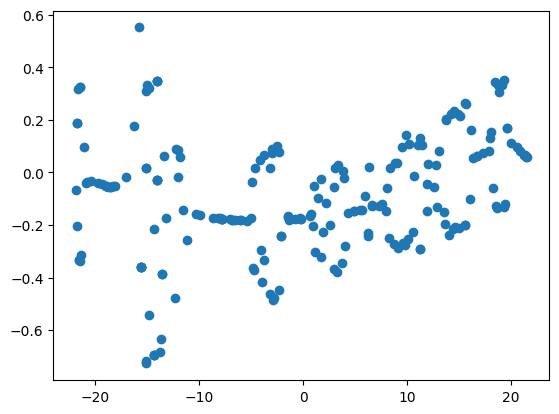

In [ ]:
# prompt: extract model activation and use tSNE cluster

# Extract activations
activations = []
model.eval()
for data in test_loader:
    _, out = model(data)
    activations.append(out.cpu())

# Concatenate activations
activations = torch.cat(activations, dim=0)

# Perform t-SNE clustering
tsne = TSNE(n_components=2)
X_embedded = tsne.fit_transform(activations.detach().numpy())

# Plot the clusters
plt.scatter(X_embedded[:, 0], X_embedded[:, 1])
plt.show()


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import NormalizeFeatures
import random

# Load the PROTEINS dataset
dataset = TUDataset(root='/tmp/PROTEINS', name='PROTEINS', transform=NormalizeFeatures())

# Data augmentation functions
def augment_data(data):
    # Node feature augmentation: Add Gaussian noise to node features
    noise = torch.randn_like(data.x) * 0.05
    data.x = data.x + noise

    # Edge perturbation: Randomly add or remove edges
    edge_index = data.edge_index.clone()
    num_edges = edge_index.size(1)

    # Randomly remove edges
    num_remove = int(0.1 * num_edges)
    remove_indices = random.sample(range(num_edges), num_remove)
    edge_index = edge_index[:, ~torch.tensor(remove_indices)]

    # Randomly add edges
    num_add = int(0.1 * num_edges)
    for _ in range(num_add):
        i, j = random.sample(range(data.num_nodes), 2)
        new_edge = torch.tensor([[i], [j]], dtype=torch.long)
        edge_index = torch.cat([edge_index, new_edge], dim=1)

    data.edge_index = edge_index
    return data

# Apply data augmentation to the dataset
augmented_dataset = [augment_data(data.clone()) for data in dataset]

# Define the GCN model for graph classification
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(42)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = torch.nn.Linear(hidden_channels, dataset.num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = global_mean_pool(x, batch)  # global mean pooling
        x = F.dropout(x, p=0.5, training=self.training)
        return x, self.lin(x)

# Initialize the model, optimizer, and dataloader
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

# Create data loaders
train_loader = DataLoader(augmented_dataset[:900], batch_size=32, shuffle=True)
test_loader = DataLoader(augmented_dataset[900:], batch_size=32, shuffle=False)

# Define the training loop
def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        optimizer.zero_grad()
        _, out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(train_loader.dataset)

# Define the test function
def test(loader):
    model.eval()
    correct = 0
    for data in loader:
        _, out = model(data)
        pred = out.argmax(dim=1)
        correct += pred.eq(data.y).sum().item()
    return correct / len(loader.dataset)

# Training loop
for epoch in range(1, 201):
    loss = train()
    if epoch % 10 == 0:
        train_acc = test(train_loader)
        test_acc = test(test_loader)
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

print('Training complete')


Epoch: 010, Loss: 0.5681, Train Acc: 0.7367, Test Acc: 0.0000
Epoch: 020, Loss: 0.5778, Train Acc: 0.7367, Test Acc: 0.0000
Epoch: 030, Loss: 0.5759, Train Acc: 0.7367, Test Acc: 0.0000
Epoch: 040, Loss: 0.5726, Train Acc: 0.7367, Test Acc: 0.0000
Epoch: 050, Loss: 0.5734, Train Acc: 0.7367, Test Acc: 0.0000
Epoch: 060, Loss: 0.5741, Train Acc: 0.7367, Test Acc: 0.0000
Epoch: 070, Loss: 0.5746, Train Acc: 0.7367, Test Acc: 0.0000
Epoch: 080, Loss: 0.5733, Train Acc: 0.7367, Test Acc: 0.0000
Epoch: 090, Loss: 0.5729, Train Acc: 0.7367, Test Acc: 0.0000
Epoch: 100, Loss: 0.5774, Train Acc: 0.7367, Test Acc: 0.0000
Epoch: 110, Loss: 0.5728, Train Acc: 0.7367, Test Acc: 0.0000
Epoch: 120, Loss: 0.5717, Train Acc: 0.7367, Test Acc: 0.0000
Epoch: 130, Loss: 0.5699, Train Acc: 0.7367, Test Acc: 0.0000
Epoch: 140, Loss: 0.5746, Train Acc: 0.7367, Test Acc: 0.0000
Epoch: 150, Loss: 0.5589, Train Acc: 0.7367, Test Acc: 0.0000
Epoch: 160, Loss: 0.5756, Train Acc: 0.7367, Test Acc: 0.0000
Epoch: 1

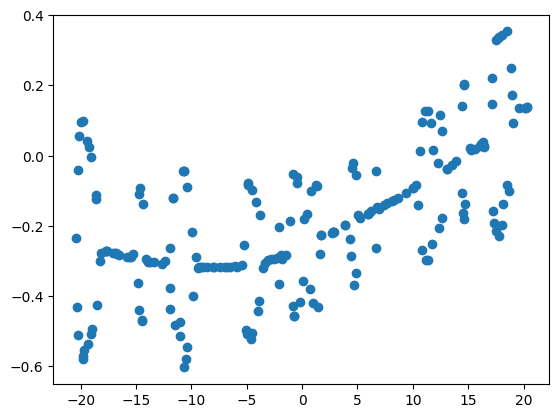

In [ ]:
# prompt: extract model activation and use tSNE cluster

# Extract activations
activations = []
model.eval()
for data in test_loader:
    _, out = model(data)
    activations.append(out.cpu())

# Concatenate activations
activations = torch.cat(activations, dim=0)

# Perform t-SNE clustering
tsne = TSNE(n_components=2)
X_embedded = tsne.fit_transform(activations.detach().numpy())

# Plot the clusters
plt.scatter(X_embedded[:, 0], X_embedded[:, 1])
plt.show()


In [ ]:
# prompt: classification report of model

from sklearn.metrics import classification_report

# Get the predictions for the test data
model.eval()
predictions = []
true_labels = []
for data in test_loader:
    _, out = model(data)
    predictions.extend(out.argmax(dim=1).tolist())
    true_labels.extend(data.y.tolist())

# Generate the classification report
report = classification_report(true_labels, predictions)
print(report)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00     213.0

    accuracy                           0.00     213.0
   macro avg       0.00      0.00      0.00     213.0
weighted avg       0.00      0.00      0.00     213.0



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

In [ ]:
# prompt: relative cluster size comparison

# Calculate the number of data points in each cluster
cluster_sizes = [len(activations_tsne[labels == i]) for i in range(dataset.num_classes)]

# Calculate the total number of data points
total_size = len(activations_tsne)

# Calculate the relative cluster sizes
relative_cluster_sizes = [size / total_size for size in cluster_sizes]

# Print the relative cluster sizes
print("Relative cluster sizes:", relative_cluster_sizes)


Relative cluster sizes: [0.5956873315363881, 0.40431266846361186]


In [ ]:
# prompt: calculate silhouette_score, davies_bouldin_score and calinski_harabasz_score
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
silhouette_score = silhouette_score(activations_tsne, labels)
davies_bouldin_score = davies_bouldin_score(activations_tsne, labels)
calinski_harabasz_score = calinski_harabasz_score(activations_tsne, labels)

print("Silhouette score:", silhouette_score)
print("Davies-Bouldin score:", davies_bouldin_score)
print("Calinski-Harabasz score:", calinski_harabasz_score)


Silhouette score: 0.1029913
Davies-Bouldin score: 2.78939736844566
Calinski-Harabasz score: 113.0058392887413


In [ ]:
# prompt: calculate WCSS score

from sklearn.cluster import KMeans
import numpy as np

# Initialize the KMeans model with the desired number of clusters
kmeans = KMeans(n_clusters=2)

# Fit the model to the data
kmeans.fit(activations_tsne)

# Calculate the WCSS score
wcss = np.sum(np.min(cdist(activations_tsne, kmeans.cluster_centers_, 'euclidean'), axis=1))

# Print the WCSS score
print("WCSS score:", wcss)


WCSS score: 24181.37802740703


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
